In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [267]:
df_cons= pd.read_csv('ConstructionTimeSeriesDataV2.csv')

## Private Construction:


This plot will display private construction spending over time. It will be used to determine what type of analysis is needed.

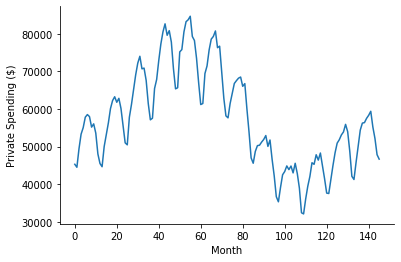

In [268]:
fig,ax = plt.subplots()
ax.plot(df_cons['Private Construction'], label= 'Private Construction Spending')  
ax.set_xlabel('Month')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The graph above displays a nonlinear trend that appears to have seasonality, over a 12 month period.

Below, the average squared error and moving average are created to help form a trended line without noise.

C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


Average Squared Error per Month:  31701673.583670188
            Month Month-Year  Total Construction  Private Construction  \
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
...           ...        ...                 ...                   ...   
2013-04-30    136     Apr-13               70535                 50022   
2013-05-31    137     May-13               77327                 54369   
2013-06-30    138     Jun-13               81722                 56228   
2013-07-31    139     Jul-13               83104                 56354   
2013-08-31    140     Aug-13               85677                 57481   

            Public Construction        MovAvg         sqEr

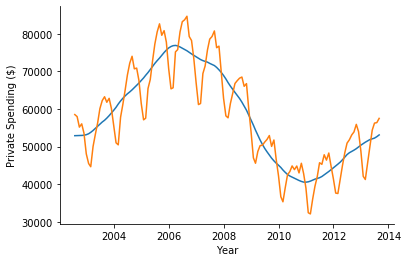

In [269]:
def sqErr(row):
    return (row['Private Construction'] - row['MovAvg'])**2
    
df_cons['MovAvg'] = np.NaN
df_cons['sqErr'] = np.NaN


df_cons.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=1), periods = len(df_cons['Private Construction']))


window = 12
window = window - window % 2


for i in range(int(window/2),df_cons.shape[0]-int(window/2)):
    df_cons.loc[df_cons.index[i],'MovAvg'] = (0.5*df_cons.iloc[i - int(window/2)]['Private Construction'] + df_cons.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum()+0.5*df_cons.iloc[i+int(window/2)]['Private Construction'])/float(window)

df_cons['sqErr'] = (df_cons['Private Construction'] - df_cons['MovAvg'])**2



df_cons.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_cons['MovAvg'],label='Moving Avg.')
ax.plot(df_cons['Private Construction'],label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_cons['sqErr'])/len(df_cons))
print(df_cons)

The best window for this data is 12 months because it holds the smallest possible average of squared errors without taking noise into effect.

New columns for R1 (Residual) and R1Error (Residual Error) are added below. 

In [270]:
df_cons['R1'] = df_cons['Private Construction'] - df_cons['MovAvg']
df_cons['R1Error'] = abs((df_cons['Private Construction'] - df_cons['R1'])/df_cons['Private Construction'])
df_cons.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1,R1Error
2002-07-31 00:00:00,7,Jul-02,78863,58494,20369,52878.2,"31,536,648.1","5,615.8",0.904
2002-08-31 00:00:00,8,Aug-02,79460,57953,21507,52892.6,"25,607,395.1","5,060.4",0.913
2002-09-30 00:00:00,9,Sep-02,76542,55157,21385,52923.7,"4,987,777.8","2,233.3",0.960
2002-10-31 00:00:00,10,Oct-02,75710,56023,19687,52945.0,"9,474,084.0","3,078.0",0.945
2002-11-30 00:00:00,11,Nov-02,71362,53552,17810,52994.5,"310,759.8",557.5,0.990
2002-12-31 00:00:00,12,Dec-02,63984,48023,15961,53142.5,"26,209,706.9","-5,119.5",1.107
2003-01-31 00:00:00,13,Jan-03,59877,45473,14404,53392.4,"62,717,160.3","-7,919.4",1.174
2003-02-28 00:00:00,14,Feb-03,58526,44620,13906,53767.5,"83,677,518.5","-9,147.5",1.205
2003-03-31 00:00:00,15,Mar-03,64506,49996,14510,54263.0,"18,207,289.0","-4,267.0",1.085
2003-04-30 00:00:00,16,Apr-03,69638,53195,16444,54821.3,"2,644,960.1","-1,626.3",1.031


The plot below is created in order to show the pattern of R1 over time. 

Average Residual:  30.595149253731616


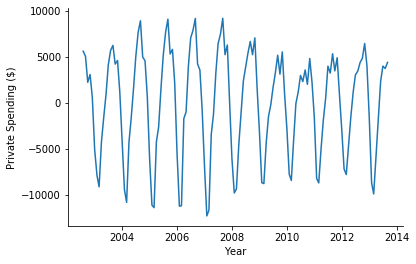

In [271]:
fig,ax = plt.subplots()
ax.plot(df_cons['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_cons['R1'])/len(df_cons))

The average residual is about 30, which is the fairly small, compaired to other window sizes larger than 12 months, and will reamin flat.

Autocorrelation is used below to search for patterns of cyclicality and to find the number of periods that pass by before repetition occurs.

In [272]:
maxCorr = 0.0
period = np.NaN
for i in range(1,13):
    corr = df_cons['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8012201439941184
Correlation, lag  2     0.4046160901273205
Correlation, lag  3     -0.06681918914657627
Correlation, lag  4     -0.46817065394656976
Correlation, lag  5     -0.7334595961596322
Correlation, lag  6     -0.8453947574465044
Correlation, lag  7     -0.7277714550926001
Correlation, lag  8     -0.45905643208796504
Correlation, lag  9     -0.06590030685316585
Correlation, lag  10     0.38876557877044954
Correlation, lag  11     0.7742521355064202
Correlation, lag  12     0.9718794492320808
period =  12      Maximum Correlation =  0.9718794492320808


The highest correlation is at lag 12, with 0.97. The cycle appears to repeat every 12 months.


This code broke the time series into 11 different sections in order to relate to the 11 cycles from the data. Each cycle is represented in a bold black line, while their average is represented in the red line above.

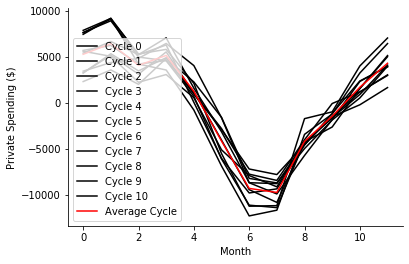

In [273]:
period = 12
cycleLen = period
numCycles = int(len(df_cons)/cycleLen + 0.5)
cycles = [df_cons.iloc[range(i*period,min((i+1)*period,len(df_cons)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df_cons.iloc[range(i,len(df_cons['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

The code below will create a new column for cyclicality demand and it will plot it against R1.

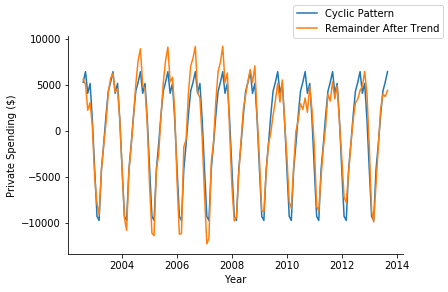

In [274]:
cycleLen = period   
numCycles = int(len(df_cons)/cycleLen + 0.5)
df_cons['C'] = np.NaN  
for i in range(len(df_cons)):
    df_cons.loc[df_cons.index[i], 'C'] = avg[i % cycleLen] 

fig,ax = plt.subplots()
ax.plot(df_cons['C'],label='Cyclic Pattern')
ax.plot(df_cons['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The code below will find the rest of the residuals in the data, or R2, and its error, R2Error. A model, 'fit', is created to display the trend and cyclicality. The model is displayed against the original data model. 

Average Error:  0.020585783569537188
            Month Month-Year  Total Construction  Private Construction  \
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
...           ...        ...                 ...                   ...   
2013-04-30    136     Apr-13               70535                 50022   
2013-05-31    137     May-13               77327                 54369   
2013-06-30    138     Jun-13               81722                 56228   
2013-07-31    139     Jul-13               83104                 56354   
2013-08-31    140     Aug-13               85677                 57481   

            Public Construction        MovAvg           R1   R1Error  \
20

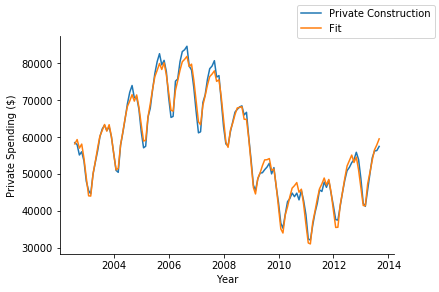

In [275]:
df_cons['R2Private'] = df_cons['R1'] - df_cons['C']
df_cons['R2ErrorPrivate'] = abs(df_cons['R2Private']/df_cons['Private Construction'])
df_cons['fit'] = df_cons['MovAvg'] + df_cons['C']
df_cons.drop(['sqErr'],axis=1,inplace=True)
print('Average Error: ', sum(df_cons['R2ErrorPrivate'])/len(df_cons))
print(df_cons)
fig,ax = plt.subplots()
ax.plot(df_cons['Private Construction'],label='Private Construction')
ax.plot(df_cons['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The average error is around zero, which is good for this case. This means that the line of fit is very close to being exactly the same as the original data. 

The code below will create a plot of R2 so that the reader can interpret patterns in the residual. The autocorrelation of the residual is calculated here as well. 

Correlation, lag  1     0.6750893529818791
Correlation, lag  2     0.34510105026697396
Correlation, lag  3     -0.04646932554791686
Correlation, lag  4     -0.31441699093452624
Correlation, lag  5     -0.5264754747503062
Correlation, lag  6     -0.5704888079897079
Correlation, lag  7     -0.46742408108255296
Correlation, lag  8     -0.25406846549220946
Correlation, lag  9     -0.05957853056153247
Correlation, lag  10     0.20420845508027602
Correlation, lag  11     0.3982803613194881
Correlation, lag  12     0.5641711274992344
period =  1      Maximum Correlation =  0.6750893529818791


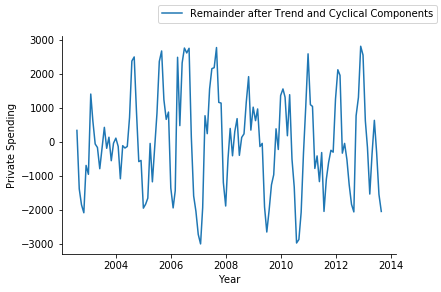

In [276]:
fig,ax = plt.subplots()
ax.plot(df_cons['R2Private'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,13):
    corr = df_cons['R2Private'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

The maximum correlation here is at period 1, at about 0.675. The data is fairly flat, trend wise. 


The plot below displays the fitted model against the original data and the residuals, R2.

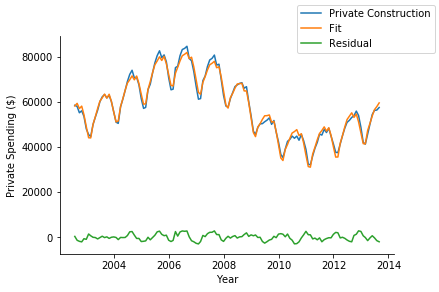

In [253]:
fig,ax = plt.subplots()
ax.plot(df_cons['Private Construction'],label='Private Construction')
ax.plot(df_cons['fit'],label='Fit')
ax.plot(df_cons['R2Private'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Private Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The residual does not vary too far away from zero, which means that the fitted model is very close to correctly modeling the actual data.

## Public Construction:


This plot will display public construction spending over time. It will be used to determine what type of analysis is needed.

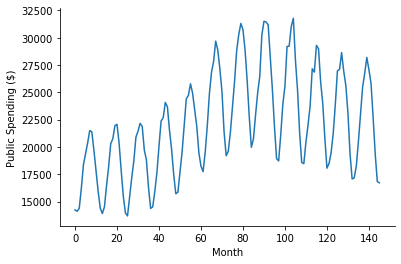

In [256]:
fig,ax = plt.subplots()
ax.plot(df_cons['Public Construction'], label= 'Public Construction Spending')  
ax.set_xlabel('Month')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The graph above displays a nonlinear trend that appears to have seasonality, over a 12 month period.

Below, the average squared error and moving average are created to help form a trended line without noise.

C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


Average Squared Error per Month:  13046470.551357789
            Month Month-Year  Total Construction  Private Construction  \
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
...           ...        ...                 ...                   ...   
2013-04-30    136     Apr-13               70535                 50022   
2013-05-31    137     May-13               77327                 54369   
2013-06-30    138     Jun-13               81722                 56228   
2013-07-31    139     Jul-13               83104                 56354   
2013-08-31    140     Aug-13               85677                 57481   

            Public Construction       MovAvg2        sqErr

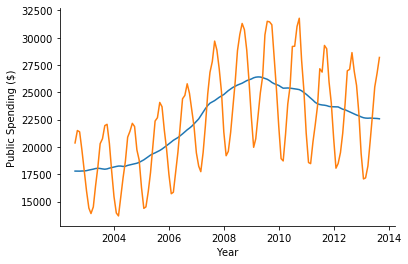

In [257]:
def sqErr2(row):
    return (row['Public Construction'] - row['MovAvg2'])**2
    
df_cons['MovAvg2'] = np.NaN
df_cons['sqErr2'] = np.NaN


df_cons.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=1), periods = len(df_cons['Public Construction']))


window2 = 12
window2 = window2 - window2 % 2


for i in range(int(window2/2),df_cons.shape[0]-int(window2/2)):
    df_cons.loc[df_cons.index[i],'MovAvg2'] = (0.5*df_cons.iloc[i - int(window2/2)]['Public Construction'] + df_cons.iloc[i - int(window2/2)+1:i + int(window2/2)]['Public Construction'].sum()+0.5*df_cons.iloc[i+int(window2/2)]['Public Construction'])/float(window2)

df_cons['sqErr2'] = (df_cons['Public Construction'] - df_cons['MovAvg2'])**2



df_cons.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_cons['MovAvg2'],label='Moving Avg.')
ax.plot(df_cons['Public Construction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_cons['sqErr2'])/len(df_cons))
print(df_cons)

The best window for this data is 12 months because it holds the smallest possible average of squared errors without taking noise into effect.

New columns for R1 (Residual) and R1Error (Residual Error) are added below. 

In [258]:
df_cons['R1Public'] = df_cons['Public Construction'] - df_cons['MovAvg2']
df_cons['R1ErrorPublic'] = abs((df_cons['Public Construction'] - df_cons['R1Public'])/df_cons['Public Construction'])
df_cons.style.format({
    'MovAvg2': '{:.1f}'.format,
    'sqErr2': '{:,.1f}'.format,
    'R1Public': '{:,.1f}'.format,
    'R1ErrorPublic': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg2,sqErr2,R1Public,R1ErrorPublic
2002-07-31 00:00:00,7,Jul-02,78863,58494,20369,17793.2,"6,634,702.7","2,575.8",0.874
2002-08-31 00:00:00,8,Aug-02,79460,57953,21507,17791.3,"13,806,488.4","3,715.7",0.827
2002-09-30 00:00:00,9,Sep-02,76542,55157,21385,17787.8,"12,939,608.0","3,597.2",0.832
2002-10-31 00:00:00,10,Oct-02,75710,56023,19687,17802.3,"3,552,125.5","1,884.7",0.904
2002-11-30 00:00:00,11,Nov-02,71362,53552,17810,17803.8,39.1,6.2,1.000
2002-12-31 00:00:00,12,Dec-02,63984,48023,15961,17834.2,"3,509,065.6","-1,873.2",1.117
2003-01-31 00:00:00,13,Jan-03,59877,45473,14404,17888.7,"12,142,901.8","-3,484.7",1.242
2003-02-28 00:00:00,14,Feb-03,58526,44620,13906,17923.5,"16,140,306.2","-4,017.5",1.289
2003-03-31 00:00:00,15,Mar-03,64506,49996,14510,17971.0,"11,978,521.0","-3,461.0",1.239
2003-04-30 00:00:00,16,Apr-03,69638,53195,16444,18026.2,"2,503,251.4","-1,582.2",1.096


The plot below is created in order to show the pattern of R1 over time.

Average Residual:  57.485074626865725


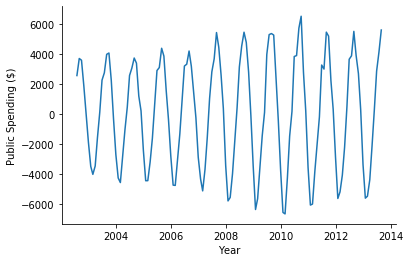

In [259]:
fig,ax = plt.subplots()
ax.plot(df_cons['R1Public'])
ax.set_xlabel('Year')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_cons['R1Public'])/len(df_cons))

The average residual is about 57, which is the fairly small, compaired to other window sizes larger than 12 months, and will reamin flat.

Autocorrelation is used below to search for patterns of cyclicality and to find the number of periods that pass by before repetition occurs.

In [260]:
maxCorr = 0.0
period = np.NaN
for i in range(1,13):
    corr = df_cons['R1Public'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8486260794687956
Correlation, lag  2     0.4813829189118816
Correlation, lag  3     -0.012518854677954341
Correlation, lag  4     -0.5037936790405376
Correlation, lag  5     -0.8444517003136985
Correlation, lag  6     -0.9648820663268396
Correlation, lag  7     -0.8433331333098901
Correlation, lag  8     -0.49319137831949866
Correlation, lag  9     0.003706338528959615
Correlation, lag  10     0.4871379355718062
Correlation, lag  11     0.8469321834384937
Correlation, lag  12     0.9888511486124667
period =  12      Maximum Correlation =  0.9888511486124667


The highest correlation is at lag 12, with 0.989. The cycle appears to repeat every 12 months.

This code broke the time series into 11 different sections in order to relate to the 11 cycles from the data. Each cycle is represented in a bold black line, while their average is represented in the red line above.

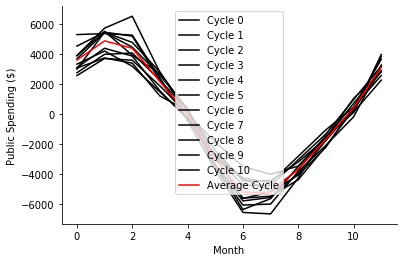

In [261]:
period = 12
cycleLen = period
numCycles = int(len(df_cons)/cycleLen + 0.5)
cycles = [df_cons.iloc[range(i*period,min((i+1)*period,len(df_cons)))]['R1Public'] for i in range(numCycles)]
ptsInCycles = [df_cons.iloc[range(i,len(df_cons['R1Public']),period)]['R1Public'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

The code below will create a new column for cyclicality demand and it will plot it against R1.

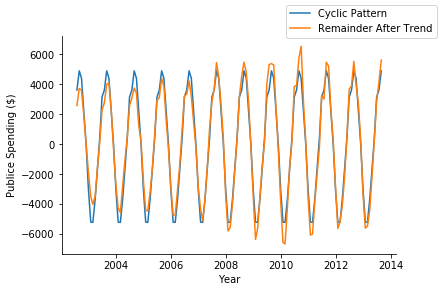

In [262]:
cycleLen = period   
numCycles = int(len(df_cons)/cycleLen + 0.5)
df_cons['C2'] = np.NaN  
for i in range(len(df_cons)):
    df_cons.loc[df_cons.index[i], 'C2'] = avg[i % cycleLen] 

fig,ax = plt.subplots()
ax.plot(df_cons['C2'],label='Cyclic Pattern')
ax.plot(df_cons['R1Public'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Publice Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The code below will find the rest of the residuals in the data, or R2, and its error, R2Error. A model, 'fit', is created to display the trend and cyclicality. The model is displayed against the original data model. 

Average Error:  0.02442412892884389
            Month Month-Year  Total Construction  Private Construction  \
2002-07-31      7     Jul-02               78863                 58494   
2002-08-31      8     Aug-02               79460                 57953   
2002-09-30      9     Sep-02               76542                 55157   
2002-10-31     10     Oct-02               75710                 56023   
2002-11-30     11     Nov-02               71362                 53552   
...           ...        ...                 ...                   ...   
2013-04-30    136     Apr-13               70535                 50022   
2013-05-31    137     May-13               77327                 54369   
2013-06-30    138     Jun-13               81722                 56228   
2013-07-31    139     Jul-13               83104                 56354   
2013-08-31    140     Aug-13               85677                 57481   

            Public Construction       MovAvg2     R1Public  R1ErrorPublic  

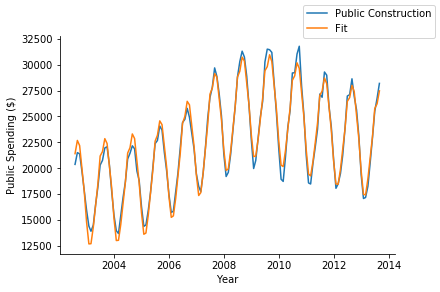

In [263]:
df_cons['R2Public'] = df_cons['R1Public'] - df_cons['C2']
df_cons['R2ErrorPublic'] = abs(df_cons['R2Public']/df_cons['Public Construction'])
df_cons['fit2'] = df_cons['MovAvg2'] + df_cons['C2']
df_cons.drop(['sqErr2'],axis=1,inplace=True)
print('Average Error: ', sum(df_cons['R2ErrorPublic'])/len(df_cons))
print(df_cons)
fig,ax = plt.subplots()
ax.plot(df_cons['Public Construction'],label='Public Construction')
ax.plot(df_cons['fit2'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The average error is around zero, which is good for this case. This means that the line of fit is very close to being exactly the same as the original data. 

The code below will create a plot of R2 so that the reader can interpret patterns in the residual. The autocorrelation of the residual is calculated here as well.

Correlation, lag  1     0.6322426709090311
Correlation, lag  2     0.3064995963745286
Correlation, lag  3     0.016615917743238257
Correlation, lag  4     -0.3749951464284437
Correlation, lag  5     -0.5745066686993782
Correlation, lag  6     -0.6360252052924398
Correlation, lag  7     -0.6425642279739693
Correlation, lag  8     -0.40902612933630556
Correlation, lag  9     -0.05927403050425125
Correlation, lag  10     0.13885056695292233
Correlation, lag  11     0.4610539680769145
Correlation, lag  12     0.6199043732843016
Correlation, lag  13     0.4898496230237448
Correlation, lag  14     0.46821963390190974
Correlation, lag  15     0.16226212150488747
Correlation, lag  16     -0.12461342222875987
Correlation, lag  17     -0.29533827350419456
Correlation, lag  18     -0.47611265244748263
Correlation, lag  19     -0.5253972732806438
Correlation, lag  20     -0.37192666568812655
Correlation, lag  21     -0.20807880214824367
Correlation, lag  22     0.013465984415997632
Correlation, la

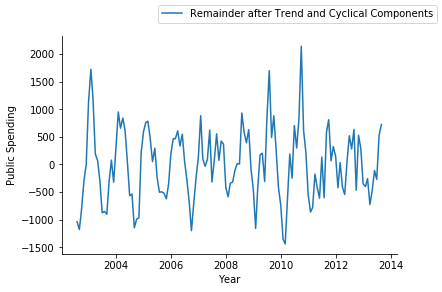

In [264]:
fig,ax = plt.subplots()
ax.plot(df_cons['R2Public'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Public Spending')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_cons['R2Public'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

The maximum correlation here is at period 1, at about 0.632. The data is fairly flat, trend wise. 

The plot below displays the fitted model against the original data and the residuals, R2.

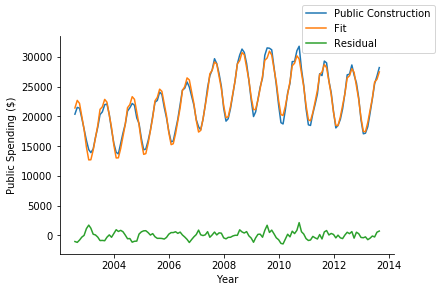

In [265]:
fig,ax = plt.subplots()
ax.plot(df_cons['Public Construction'],label='Public Construction')
ax.plot(df_cons['fit2'],label='Fit')
ax.plot(df_cons['R2Public'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Public Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The residual does not vary too far away from zero, which means that the fitted model is very close to correctly modeling the actual data.